# Analysis Summary
*Fraud is a special customer behavior that shares certain patterns. Understand how the customer behavior / demongraphic information correlated with their fraud activity is the goal of this analysis. *

<div class="alert alert-block alert-info">
<b>1. Patterns discovered in the analysis are:</b><br>
- (1) more than half of fraud customer purchase immediately after they sign  <br>
- (2) if the device the customer used has been used before, then there is a high risk the first transaction of the customer is fraud <br>

<b>2. Model Selection :</b><br>
- (1) Use ROC-AUC score to evaluate the classification model accuracy  <br>
- (2) Consider Recall more than Precision as here it is more important to predict true positive but we care less about false posive  <br>
- (3) Use random forest variable importance to identify the contributory factor to fraud. As rf average out the <br>
- (4) To tune model, using randomized cv and grid search. <br><br>

<b>3. Real-Time fraud detection application :</b><br>
__Decide the threshhold of probability of fraud score to take further consideration before put the model inapplication__ <br>
(1) understand the cost for the case that a. fraud was not detected b. a normal transaction was tagged as fraud.   <br>
(2) conduct a cost-benefit analysis to maximize profit, i.e. if situation a cost 1 dollar and situation b cost 10 dollar, then the tolerance of b could be 10x as the tolerance of a.    <br>
(3) considering other criterias and draw a practical cut i.e. for default =1 , (1-recall)=0.1(1-precision)   <br>
__Draw 2 threshold__ *(please refer to the green box below for further detail)* <br>
(1) a threshold with a good confidence that the instance is fraud. <br>
(2) a threshold that the instance is problematic or suspicious, need future scruitiny  <br>
__Life testing__  <br>
(1) Feed the life data to the model and check the probability score of fraud.  <br>
(2) If the score is higher than the stricter threshold, tag it as fraud. If the score is between a and b, then put it into more scruitiny check <br>
(3) Use out of sample data to test the existing model in a regular basis, to make sure the model is still robust to current situation <br>
(4) Use new information to train data to make the model adapt to new information <br>

</div>


# Analysis Plan
###  1. EDA -- understand the input variable 
  * -- understand unit of analysis
  * -- understand data type and single var distribution
  * -- understand data correlation, esp to the target variable

###  2.a Data Cleaning 
  * -- missing value inpute (a. whether missing value is correlated with fraud, b. how missing value be estimated)
  * -- outlier check
  * -- understand data type and single var distribution (a.bar chart for categorical var and histograph for continuous var)
  * -- understand data correlation, esp to the target variable
  * -- scale (ratio scale for numerical var and nominal scale for object to categories)

### 2.b Feature Engineering 
  * -- with industry experience and based on common sense, create var
  * -- observe correlation and model output to modify variable
  * -- understand data correlation, esp to the target variable
  * -- scale (ratio scale for numerical var and nominal scale for object to categories)

### 3. Model Building & Model Evaluation 
  * -- using tree and rf to check variable importance
  * -- Use gradient boost as there might be couple models that suitable for different part of the instances
  * -- Check metrics ROC-AUC
  * -- Hyper Parameter Tuning Cross Validation and Randomized v
  * -- Real case analysis : model interpretation
  * -- Use demo


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [47]:
fraud_df=pd.read_csv("Fraud_Data.csv")
IP_to_country_dict=pd.read_csv("IpAddress_to_Country.csv")

###  1. EDA -- understand the input variable 
   - understand unit of analysis

In [48]:
pd.DataFrame(np.vstack([fraud_df.dtypes,fraud_df.nunique()]).T,index=fraud_df.columns,columns=['type','nunique'])

,type,nunique
user_id,int64,151112
signup_time,object,151112
purchase_time,object,150679
purchase_value,int64,122
device_id,object,137956
source,object,3
browser,object,5
sex,object,2
age,int64,58
ip_address,float64,143512


<div class="alert alert-block alert-info">
<b>Findings:</b><br>*- one unit is one user, and each user have a unique signup time :use user_id as unique identifier and unit of analysis  <br>
*- device_id and ip_address is mostly identical for all users, but dupes exists -- for device, check why customers share same device, and whether it is relavent with fraud
</div>

###  2. Data Cleaning & Feature Engineer
 *  __(Task 1) IP_adress and country mapping__

In [49]:
IP_to_country_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [50]:
IP_to_country_dict.groupby(['country'])['lower_bound_ip_address'].count().sort_values(ascending=False).head()

country
United States         46868
Canada                 6989
Russian Federation     6739
Australia              6316
Germany                5999
Name: lower_bound_ip_address, dtype: int64

<div class="alert alert-block alert-info">
<b>Mapping IP Address to Country - Findings:</b><br>
-There are overall 235 countries but some country have very few customers. In later cleaning up step, combining those small countries might be needed to reduce the dimension<br>
-by checking the upper bound and lower bound range, compared with the IP_address range of the dictionary, we find the IP_to_country_dict ip address range does __not cover all__ IP address in the raw data. <br><br>
<b>the following logic will take care of this, and will also take care of anywhere the range is not covered</b><br>
</div>

In [51]:
pd.options.display.float_format = '{:,.2f}'.format
IP_to_country_dict.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,"138,846.00","138,846.00"
mean,"2,724,531,562.52","2,724,557,062.22"
std,"897,521,519.71","897,497,915.46"
min,"16,777,216.00","16,777,471.00"
25%,"1,919,930,368.00","1,920,008,191.00"
50%,"3,230,887,296.00","3,230,887,551.00"
75%,"3,350,465,280.00","3,350,465,919.00"
max,"3,758,096,128.00","3,758,096,383.00"


In [52]:
pd.options.display.float_format = '{:,.2f}'.format
fraud_df['ip_address'].describe().min(),fraud_df['ip_address'].describe().max()

(52093.4968949854, 4294850499.6788397)

In [53]:
def mapcount(x):
    ## find the row index that ip address falls into the range in IP_to_country_dict
    ## if there is no corresponding range covers certain ip_address, it will be mapped to 'NA'

    K=(IP_to_country_dict['upper_bound_ip_address']>=x) &(IP_to_country_dict['lower_bound_ip_address']<=x)
    if any(K) :
        return (IP_to_country_dict['country'][K].get_values()[0])
    else:
        return ('NA')

In [54]:
#fraud_df['ip_address'].values

In [56]:
country=[]
for i in fraud_df['ip_address']:
    country.append(mapcount(i))

In [58]:
fraud_df['country']=country

In [59]:
#fraud_df.columns

* save the output to a file as the mapping takes long

In [60]:
## fraud_df.to_csv('fraud_df_with_Country.csv')
#fraud_df.head()
#fraud_df=pd.read_csv('fraud_df_with_Country.csv',index_col=0)

* check how the fraud rate is associated with country, if there is no difference, then just combine those rare country to others, to reduce the feature dimension

In [61]:
print(fraud_df['country'].value_counts().sort_values(ascending=False).head())
print(fraud_df['country'].value_counts().sort_values(ascending=False).count())

United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Name: country, dtype: int64
181


- in total 181 countries mapped, but the customer distribution is skewed. 
- Check whether I can short this list by group the long tail into one bucket

In [62]:
fraud_df['country']=fraud_df['country'].fillna('NA')

* only keep the top 50 countries by descending frequency

In [63]:
d=list(fraud_df['country'].value_counts()[:50].index.get_values())

* replace the country with other if they are not on the top 50 list

In [64]:
fraud_df['country_simplified']=[x if x in d else 'Others' for x in fraud_df['country'] ]

In [65]:
country_fraud=fraud_df.groupby(['country_simplified']).agg({'class':[np.mean,np.size]})
country_fraud.columns=['mean', 'size']

In [67]:
pd.options.display.float_format = '{:,.2f}'.format
country_fraud.sort_values(by=['mean'],ascending=False).iloc[1:-1:5,:]

,mean,size
country_simplified,,
New Zealand,0.22,278
Belgium,0.14,409
Mexico,0.13,1121
Iran (ISLAMIC Republic Of),0.11,389
Finland,0.10,460
Brazil,0.09,2961
Indonesia,0.09,649
Taiwan; Republic of China (ROC),0.08,1237
Spain,0.07,1027


In [10]:
print('All customers that IP address can not matched with a country are with fraud rate {:.3f}'.format(country_fraud.loc['NA'][0]))
print('All customers that IP address matched to a country casted as ''other'' are with fraud rate {:.3f}'.format(country_fraud.loc['Others'][0]))
print('All other countries (except for NAs and Others) fraud rate is {:.3f}'.format(fraud_df[(fraud_df['country']!='NA')&(fraud_df['country']!='Others')]['class'].mean()))

All customers that IP address can not matched with a country are with fraud rate 0.086
All customers that IP address matched to a country casted as other are with fraud rate 0.094
All other countries (except for NAs and Others) fraud rate is 0.095


<div class="alert alert-block alert-info">
<b>Mapping Process Summary:</b><br>* 1. mapped the IP_address to country with logic designed*<br>* 2. filled missing value *<br>* 3. bucketed the customers in less appeared countries into 'other' category *<br>* 4. validation: the fraud rate of NA is 0.09, the fraud rate of other is also 0.09. same as the rest of the country fraud rate. So this group works*
</div>

###  2. Data Cleaning & Feature Engineer
  * __Time-Related variables__ : <br>
    -- understand the time range <br>
    -- turn time to numerical var <br>
    -- find other feature and check correlation with target var <br>

In [68]:
fraud_df['purchase_time_stamp']=pd.to_datetime(fraud_df['purchase_time'])
fraud_df['signup_time_stamp']=pd.to_datetime(fraud_df['signup_time'])

* check the sign up and purchase time distribution

In [69]:
#check range
print('time span of purchase time is {} to {}'.format(min(fraud_df['purchase_time_stamp']),max(fraud_df['purchase_time_stamp'])))
print('time span of purchase time is {} to {}'.format(min(fraud_df['signup_time_stamp']),max(fraud_df['signup_time_stamp'])))

time span of purchase time is 2015-01-01 00:00:44 to 2015-12-16 02:56:05
time span of purchase time is 2015-01-01 00:00:42 to 2015-08-18 04:40:29


* as there is only one year covered, it would be ideal to bucket the time into months

In [70]:
fraud_df['Purch_Month']=[x.month for x in fraud_df['purchase_time_stamp']]
fraud_df['signup_Month']=[x.month for x in fraud_df['signup_time_stamp']]

In [71]:
print(fraud_df.groupby('signup_Month')['class'].agg({'Average Fraud Rate': np.average, 'Number of Customers': np.size}))
print('\n')
print(fraud_df.groupby('Purch_Month')['class'].agg({'Average Fraud Rate': np.average, 'Number of Customers': np.size}))

              Number of Customers  Average Fraud Rate
signup_Month                                         
1                           26978                0.31
2                           17535                0.05
3                           19555                0.04
4                           18895                0.05
5                           19338                0.04
6                           18633                0.05
7                           19454                0.05
8                           10724                0.05


             Number of Customers  Average Fraud Rate
Purch_Month                                         
1                          10097                0.76
2                           6449                0.05
3                          12090                0.05
4                          16551                0.04
5                          19364                0.05
6                          18908                0.04
7                          19507  

C:\Users\Yilun\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':
C:\Users\Yilun\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


                     Number of Customers  Average Fraud Rate
        signup_Month                                         
        1                           26978                0.31
        2                           17535                0.05
        3                           19555                0.04
        4                           18895                0.05
        5                           19338                0.04
        6                           18633                0.05
        7                           19454                0.05
        8                           10724                0.05
        
        
                     Number of Customers  Average Fraud Rate
        Purch_Month                                         
        1                          10097                0.76
        2                           6449                0.05
        3                          12090                0.05
        4                          16551                0.04
        5                          19364                0.05
        6                          18908                0.04
        7                          19507                0.05
        8                          18662                0.04
        9                          14347                0.05
        10                          9815                0.05
        11                          4743                0.05
        12                           579                0.06

<div class="alert alert-block alert-info">
<b>Findings - Signup and purchase time:</b><br>
* 1. Apart from month 1, the fraud rate for all months are similar. So here have purchase_month=1 and signup_month=1 as a separate var<br>
* 2. 31% of transactions that customers signed up Jan-15 fraud.<br>
* 3. 76% of customer purchased Jan-15 fraud.<br>
* 4. Analyze how the interval between sign and purchase play a role here <br>
</div>

In [72]:
fraud_df['Sign_to_Purch']=fraud_df.apply(lambda x:x['purchase_time_stamp']-x['signup_time_stamp'],axis=1)

* convert the time interval to numerical

In [73]:
import datetime as dt
# introduce time interval and make the time dif as numeric
fraud_df['Sign_to_Purch_day']=fraud_df['Sign_to_Purch']/dt.timedelta(days=1)

* the overall default customers are 14k, appx. 10% of the overall volumn

* check how the sign-to-purchase time gap correlate with fraud

In [74]:
fraud_df[['Sign_to_Purch_day','class']].corr()

,Sign_to_Purch_day,class
Sign_to_Purch_day,1.00,-0.26
class,-0.26,1.00


* the longer time interval between sign and purchase, the less likely it is a fraud

In [75]:
print('Overall fraud distribution \n',fraud_df.groupby(['class']).size(),'\n')
print('Average Sign up to Purchase day interval by fraud class \n', fraud_df[['Sign_to_Purch_day','class']].groupby('class').mean())

Overall fraud distribution 
 class
0    136961
1     14151
dtype: int64 

Average Sign up to Purchase day interval by fraud class 
        Sign_to_Purch_day
class                   
0                  60.08
1                  28.05


* fraud customers have shorter time interval between sign up and the first purchase, attested the original assumption
* want to check the detailed pattern, as is there any particular time interval fraud customers usually have
  -- from below we can see all customer sign and purchae immediately <0.001 days are all fraud

In [77]:
pd.options.display.float_format = '{:,.3f}'.format
##print(fraud_df.groupby('Sign_to_Purch_day')['class'].agg({'Average Fraud Rate':np.mean,'Size':np.size}))
print(fraud_df.groupby('Sign_to_Purch_day')['class'].agg({'Average Fraud Rate':np.mean,'Size':np.size}).iloc[::10000,:])

C:\Users\Yilun\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  from ipykernel import kernelapp as app


                   Size  Average Fraud Rate
Sign_to_Purch_day                          
0.000              7600                   1
8.523                 1                   0
16.999                1                   0
25.164                1                   0
33.539                1                   0
42.030                1                   0
50.390                1                   0
58.663                1                   0
67.001                1                   0
75.292                1                   0
83.671                1                   0
92.037                1                   0
100.392               1                   0
108.708               1                   0
117.068               1                   0


In [78]:
fraud_df['Sign_to_Purch_Same']=fraud_df['Sign_to_Purch_day']<0.001

In [79]:
pd.crosstab(fraud_df['Sign_to_Purch_Same'],fraud_df['class'])

class,0,1
Sign_to_Purch_Same,,
False,136961,6551
True,0,7600


<div class="alert alert-block alert-info">
<b>Findings - Signup and purchase time (2) interval :</b><br>
 1. 7600 Out of the total 14151 fraud are customer sign up and buy immediately. <br>
 2. All customer sign and buy immediately are fraud customers <br>
<b>Feature Engineer :</b><br>
keep 2 derived feature from time attributes<br>
1 Signup to Purchase would be a continuous var. <br> 2 And one binary var indicating whether the customer purchase immediately after signup could also useful <br>
</div>

###  2. Data Cleaning & Feature Engineer
  * __Device_Id__ 
  * (1) distribution of # devices used more than once across the timeperiod
  * (2) how multi-time used device correlated with fraud 

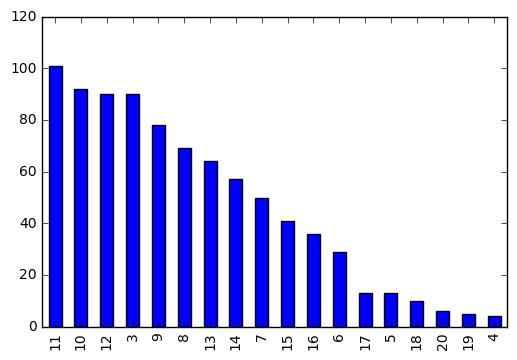

In [25]:
fraud_df['device_id'].value_counts()[fraud_df['device_id'].value_counts()>2].value_counts().plot.bar()

In [26]:
dupe_device_and_dupe_times=fraud_df['device_id'].value_counts()

dupe_device_and_dupe_times

device_time_used=pd.DataFrame(dupe_device_and_dupe_times).rename(columns={'device_id':'device_id_TimeUsed'})

device_time_used.index.names=['device_id']

fraud_df=fraud_df.join(device_time_used, on='device_id',how='left')

* check how fraud is correlated with deviced time used

In [27]:
fraud_df[['device_id_TimeUsed','class']].corr()

,device_id_TimeUsed,class
device_id_TimeUsed,1.000,0.671
class,0.671,1.000


In [28]:
DeviceUsedTimes_vs_Fraud=pd.crosstab(fraud_df['device_id_TimeUsed'],fraud_df['class'])

In [29]:
DeviceUsedTimes_vs_Fraud['Fraud_Ratio']=pd.crosstab(fraud_df['device_id_TimeUsed'],fraud_df['class']).apply(lambda x:x[1]/sum(x),axis=1)

In [30]:
DeviceUsedTimes_vs_Fraud['Fraud_Ratio']

device_id_TimeUsed
1    0.030
2    0.229
3    0.244
4    0.625
5    0.800
6    0.828
7    0.860
8    0.875
9    0.889
10   0.899
11   0.908
12   0.919
13   0.922
14   0.927
15   0.924
16   0.934
17   0.937
18   0.939
19   0.947
20   0.950
Name: Fraud_Ratio, dtype: float64

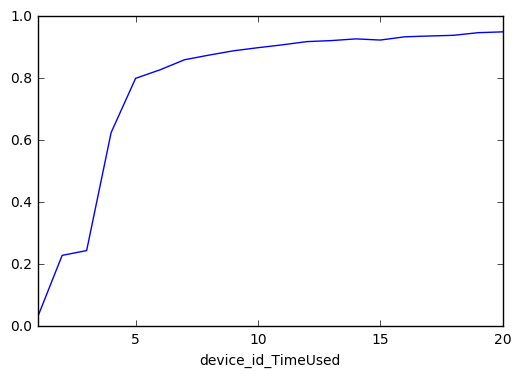

In [31]:
DeviceUsedTimes_vs_Fraud['Fraud_Ratio'].plot()

* if the device is used by 2 & 2+ customers, the fraud rate is much higher than normal.

<div class="alert alert-block alert-info">
<b>Findings - Multi-used Device_ID :</b><br>
* If one device_id is used multiple times within this time range<br>
-- the transaction with device_id used 2-4 times is of 10X default rate compared with transactions with device_id only appeared once.<br>
-- the transaction with device_id used 5+ times is of 30X default rate compared with transactions with device_id only appeared once.<br>

<b>Feature Engineer  :</b><br>
* This variable include information for future train and test set. So need further operation when comming to modeling<br>
-- Use only training set device information to create the 'number used' tagging.<br>
-- In model validation, the variable should be whether the device id was in the training dataset.<br>
-- In real-time testing, use time series to check whether the device id has appeard in the history or not. <br>

###  2. Data Cleaning & Feature Engineer
  * __Other Metrics Scale__ 
   - numerical : purchase_value -- distribution and whether need to transform
   - categorical : source, country, browser, sex

* check whether need to scale purchase value

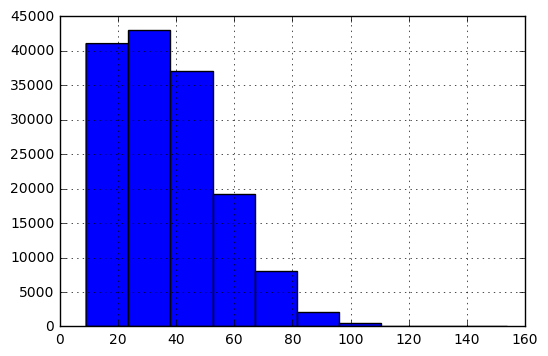

In [32]:
fraud_df['purchase_value'].hist()

In [39]:
fraud_df.groupby(['class'])['purchase_value'].mean()

class
0   36.9294
1   36.9930
Name: purchase_value, dtype: float64

In [82]:
print(pd.crosstab(fraud_df['class'],fraud_df['sex']))

sex        F      M
class              
0      57102  79859
1       5717   8434


<div class="alert alert-block alert-info">
<b>Other Variables -- Scale Approach :</b><br> 
  - 'purchase_value' distribution is pretty close to normal, no need to scale <br> 
  - for other binary variable, use 'LabelEncoder' to transform  <br> 
  - for other categorical variables, as they are not ordinal, use pandas 'get_dummy' to transform. <br> 
</div>

In [33]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
fraud_df['sex'] = enc.fit_transform(fraud_df['sex'])
fraud_df['Sign_to_Purch_Same'] = enc.fit_transform(fraud_df['Sign_to_Purch_Same'])
fraud_df['Purch_Month_Jan'] = enc.fit_transform(fraud_df['Purch_Month']==1)
fraud_df['signup_Month_Jan'] = enc.fit_transform(fraud_df['signup_Month']==1)


* check the correlation before transform to categorical vars

In [34]:
one_hot=pd.get_dummies(data=fraud_df.drop(columns=[ 
            ##remove columns that been simplified or transformed
            ##keep deviceid here for var generation after train-test split
            'signup_time', 'purchase_time', 'ip_address', 'country',
            'purchase_time_stamp', 'signup_time_stamp', 'Sign_to_Purch'
            ]).set_index('user_id'),
            ##transform categorical variables
                       columns=[ 'source', 'browser', 'country_simplified'])

In [35]:
one_hot.iloc[0]

purchase_value                                                   34
device_id                                             QVPSPJUOCKZAR
sex                                                               1
age                                                              39
class                                                             0
Purch_Month                                                       4
signup_Month                                                      2
Sign_to_Purch_day                                            52.161
Sign_to_Purch_Same                                                0
device_id_TimeUsed                                                1
Purch_Month_Jan                                                   0
signup_Month_Jan                                                  0
source_Ads                                                        0
source_Direct                                                     0
source_SEO                                      

In [ ]:
# check output view columns
for i in one_hot.columns:
    if not i.startswith('country'):
        print(i)

### 3. Model Building & Model Evaluation 

In [10]:
from sklearn.cross_validation import train_test_split

In [11]:
# evaluation
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [13]:
# from numpy.core.umath_tests import inner1d

In [14]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [15]:
from sklearn.grid_search import RandomizedSearchCV, GridSearchCV

In [42]:
X_train,X_test,y_train,y_test=train_test_split(one_hot.drop(columns='class'),one_hot['class'],random_state=200,test_size=0.5)

In [44]:
#X_train.columns

In [45]:
y_train.value_counts()

0    68402
1     7154
Name: class, dtype: int64

In [46]:
X_test.shape

(75556, 70)

In [47]:
y_test.value_counts()

0    68559
1     6997
Name: class, dtype: int64

<div class="alert alert-block alert-info">
<b>Modeling Preprocessing 1 -- Rebuild Variable indicating whether the device has been used or not  :</b><br> 
  * - To avoid data leakage - rework on device_id_TimeUsed, to make it only include information for training set   <br> 
  * - Modify the variable. Have the value in training set minus 1 *__so not include the sample itself__*  to make it comparable between training and testing set   <br> 
</div>


In [48]:
# re generate 'device_id_TimeUsed'
dupe_device_and_dupe_times=X_train['device_id'].value_counts()

dupe_device_and_dupe_times

device_time_used=pd.DataFrame(dupe_device_and_dupe_times).rename(columns={'device_id':'device_id_TimeUsed'})

device_time_used.index.names=['device_id']

In [49]:
X_train=X_train.drop(columns=['device_id_TimeUsed']).join(device_time_used, on='device_id',how='left')
X_test=X_test.drop(columns=['device_id_TimeUsed']).join(device_time_used, on='device_id',how='left')

# among the test data, there should be a lot of device that have not appeared in X_train, fill them with 
sum(X_test['device_id_TimeUsed'].isnull())
X_test['device_id_TimeUsed_before']=X_test['device_id_TimeUsed'].fillna(0)

In [50]:
X_test['device_id_TimeUsed_before'].value_counts()

0.000     68696
1.000      2753
5.000       809
6.000       712
4.000       577
7.000       531
8.000       373
3.000       368
2.000       327
9.000       209
10.000      107
11.000       50
13.000       24
12.000       15
15.000        5
Name: device_id_TimeUsed_before, dtype: int64

In [ ]:
# in the training data, # of device used include the transaction itself. 
# To make it comparable to the concept used in the test data, use 'device_id_TimeUsed_before' 
X_train['device_id_TimeUsed_before']=X_train['device_id_TimeUsed']-1

X_train['device_id_TimeUsed_before'].value_counts()

In [65]:
X_train.drop(columns=['device_id_TimeUsed'],inplace=True)
X_test.drop(columns=['device_id_TimeUsed'],inplace=True)

In [63]:
X_train['device_used_before']=X_train['device_id_TimeUsed_before']>0
X_test['device_used_before']=X_test['device_id_TimeUsed_before']>0

In [64]:
print(X_train.shape,X_test.shape)

(75556, 71) (75556, 71)


<div class="alert alert-block alert-info">
<b>Modeling Preprocessing 2  -- Deal with inbalanced sample  :</b><br>
Down sampling - the overall target value is not balanced. The target is in a 10% to 90% distribution. Here downsample the larger group with the same # as the smaller one  <br> 
</div>

* training data balance - down sampling

In [67]:
indextrain_N=y_train[y_train==1][:7154].index.get_values()
indextrain_P=y_train[y_train==0][:7154].index.get_values()

ln=list(indextrain_N)
ln2=list(indextrain_P)
ln.extend(ln2)

X_train=X_train.drop(columns=['device_id']).loc[ln]
y_train=y_train.loc[ln]

In [68]:
X_test=X_test.drop(columns=['device_id'])

In [69]:
len(indextrain_N)

7154

In [ ]:
# keep backup the training and testing data
# X_test.to_csv('X_test.csv')
# X_train.to_csv('X_train.csv')
# y_test.to_csv('y_test.csv')
# y_train.to_csv('y_train.csv')

In [6]:
X_test=pd.read_csv('X_test.csv',index_col=0)
X_train=pd.read_csv('X_train.csv',index_col=0)

In [7]:
y_train=pd.read_csv('y_train.csv',header=None,index_col=0)
y_train.columns=['class']
y_train.index.name='user_id' #y_train_1.index=['user_id']
y_train['class'].value_counts()

1    7154
0    7154
Name: class, dtype: int64

In [8]:
y_test=pd.read_csv('y_test.csv',header=None,index_col=0)
y_test.columns=['class']
y_test.index.name='user_id' #y_train_1.index=['user_id']
y_test['class'].value_counts()

0    68559
1     6997
Name: class, dtype: int64

In [19]:
y_test=y_test['class']
y_train=y_train['class']

<div class="alert alert-block alert-info">
**Modeling Summary** <br><br>
<b>1.Select model based on evaluation metric   :</b><br>
comparing the 4 models used here:<br> 
 - logistic regression and random forest and ada-boost are with similar ROC-AUC  <br> 
 - logistic regression provided a higher recall for 'Fraud' class  <br> 
 - svm model provide higher precision but does not excel overall  <br> 
 - logistic regression is easy to explain and interprete  <br> 
evaluation metric:<br> 
 - 'Recall' is a more important metric than 'Precision' as we are more interested in True Positive, but less concerned about False Positive. <br><br>
 
<b>2.Factor Analysis   :</b><br>
by analyzing 'value importance' of the variables in logistic regression and rf model, we can see <br> 
 - whether the device is used more than once is mostly associated with fraud, and the more the device was shared by different customer, the more likely fraud happens<br> 
 - similarly, the shorter the customer purchase after they sigh up, the more likely the purchase is a fraud transaction. And an immediate purchase have additional power in predicting fraud. <br> 
 - other factors, including country, age, browser, source, the month of purchase happend, the month sign-up, does not have much predictive power for the fraud transaction <br> 
</div>

<div class="alert alert-block alert-info">
<b>Model 1: Logistic Regression</b><br>
__Modeling__<br>
Apply with grid search  <br> 
__Result__<br>
The model can predict 60% of the fraud with good accuracy  <br> 
__Application__<br>
Based on the ROC curve, draw the threshold that apply to practical testing  <br> 
</div>

In [16]:
log=LogisticRegression( class_weight='auto')
log.fit(X_train,y_train)
pred=log.predict(X_test)
print(classification_report(y_test,pred))

C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Yilun\Anaconda3\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


             precision    recall  f1-score   support

          0       0.96      0.96      0.96     68559
          1       0.64      0.62      0.63      6997

avg / total       0.93      0.93      0.93     75556



                 precision    recall  f1-score   support
    
              0       0.96      0.96      0.96     68559
              1       0.64      0.62      0.63      6997
    
    avg / total       0.93      0.93      0.93     75556

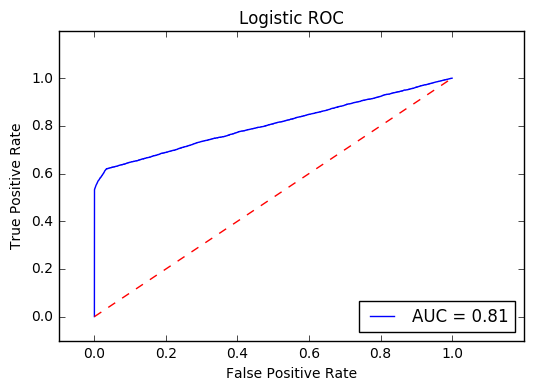

In [17]:
# TPR Increased at the beginning 60-70%  and then not effective
y_pred = log.predict_proba(X_test)
predictions = y_pred[:,1]
actual=y_test

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Logistic ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*__apply grid search__*

In [20]:
# cv
log=LogisticRegression(class_weight="balanced")
params = {'C':[0.01,0.1,1,10]}
loggrid = RandomizedSearchCV(estimator=log,param_distributions=params,cv=5,scoring='recall',n_iter=3)
loggrid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'C': [0.01, 0.1, 1, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='recall', verbose=0)

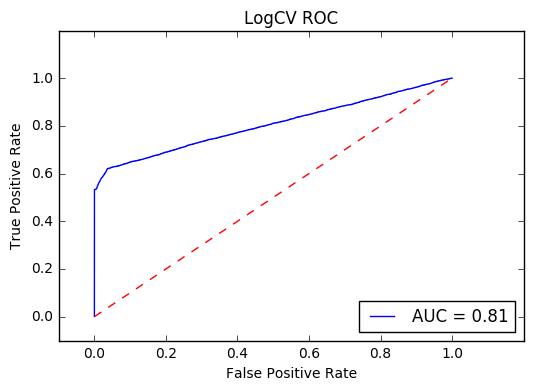

In [21]:
y_pred = loggrid.predict_proba(X_test)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LogCV ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
# based on auc curve of the logistic regression model, create the trade off between FPR and TPR, with their corresponding threshold
roc=pd.DataFrame([false_positive_rate, true_positive_rate, thresholds],index=['FPR','TPR','TH'])
K=roc.T

In [30]:
pd.options.display.float_format = '{:,.4f}'.format
print(K.iloc[::1000,:])

        FPR    TPR     TH
0    0.0000 0.0007 0.9994
1000 0.0145 0.5670 0.7202
2000 0.1007 0.6484 0.3251
3000 0.2589 0.7169 0.2966
4000 0.4247 0.7809 0.2805
5000 0.5698 0.8371 0.2717
6000 0.7237 0.8922 0.2625
7000 0.8719 0.9523 0.2508


*__the True Positive Rate and False Positive Rate trade off, with threshold__* <br>

         FPR    TPR     TH
         0.0000 0.0007 0.9994
         0.0145 0.5670 0.7202
         0.1007 0.6484 0.3251
         0.2589 0.7169 0.2966
         0.4247 0.7809 0.2805
         0.5698 0.8371 0.2717
         0.7237 0.8922 0.2625
         0.8719 0.9523 0.2508

<div class="alert alert-block alert-success">
<b>__For real time use, we can apply 2 threshold for 2 levels of actions__</b><br><br>
__level 1: confident that the case is fraud__ <br>
         -- select threshold yield low FPR, in this case, predict_probability>0.72, which correspond to a FPR=1%, very small. <br>
         __action :__ the purchase could be tagged as fraud and the merchant can decline the transaction immediately. <br><br>
__level 2: find the instance suspicious and need futher scrutiny.__ <br>
         -- Cost-Benefit analysis Assumption: <br>
         one false positive case cost 4 dollars (the potential profit of one transaction, 10% of the average transaction amount) <br> 
         and one false negative case cost 40 dollars (The average purchase_price) <br>
         -- the balance point is calculatedby (1-TPR)*10=FPR, which is predict_probability~=0.25  <br>
         __action :__ company could have additional staff to look into the transaction for further information depending on the business. <br>
</div>

<div class="alert alert-block alert-info">
<b>Model 2: Random Forest </b><br>
__Modeling__<br>
Apply with grid search for hyper parameter tuning  <br> 
Apply ADA Boost to enhance the model  <br> 
__Result__<br>
The evaluation metrics does not improve much compared to logistic regression  <br> 
__Application__<br>
Analyse what feature is important in the prediction  <br> 
</div>

In [130]:

params = {'max_depth': [3,5,7,9,11,15], 'min_samples_leaf':[2, 4, 8,12,16]}
rfgrid = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=3,scoring='recall',n_iter=3)
rfgrid.fit(X_train,y_train)
pred=rfgrid.predict(X_test)
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96     68559
          1       0.63      0.62      0.63      6997

avg / total       0.93      0.93      0.93     75556



In [131]:
rfgrid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

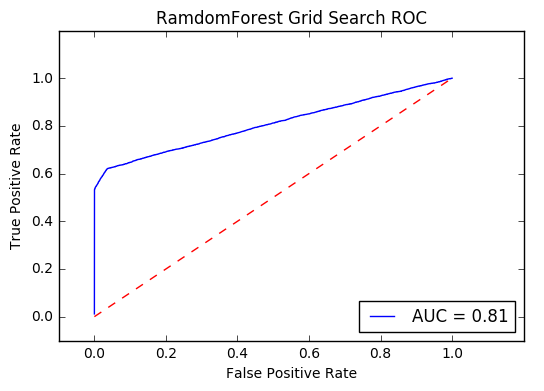

In [132]:
y_pred = rfgrid.predict_proba(X_test)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('RamdomForest Grid Search ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [133]:
#rfgrid.best_estimator_

importances = rfgrid.best_estimator_.feature_importances_

std=np.std(X_train, 0)

#rfgrid.best_estimator_.feature_importances_

In [138]:
RF_Var_Importance=round(pd.DataFrame(np.stack((rfgrid.best_estimator_.feature_importances_,std)).T,
                                    index=X_train.columns.get_values(),columns=['Imp','Std']),2).sort_values('Imp',ascending=False).head(7)

RF_Var_Importance.to_csv('RF_Var_Importance.csv')

In [ ]:
print(RF_Var_Importance)

<div class="alert alert-block alert-info">
<b>__Random Forest Model showing the following features are highly correlated with fraud purchase__</b> <br>
- 1a if the device been used<br> 
- 1b the more times a device is used <br>
- 2a if the customer purchase immediately after they sigh up <br>
- 2b also the shorter a customer made their first purchase after they signup <br>
</div>

                                            Imp    Std
                device_id_TimeUsed_before 0.320  2.740
                Sign_to_Purch_Same        0.240  0.440
                device_used_before        0.160  0.470
                Sign_to_Purch_day         0.100 39.960
                Purch_Month               0.090  3.150
                Purch_Month_Jan           0.050  0.450
                purchase_value            0.010 18.420

* adaboost

In [141]:
ada=AdaBoostClassifier(base_estimator=rfgrid.best_estimator_,n_estimators=4)
ada.fit(X_train,y_train)
pred=ada.predict(X_test)
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.96      0.97      0.96     68559
          1       0.64      0.62      0.63      6997

avg / total       0.93      0.93      0.93     75556



In [142]:
params = {'max_depth': [2,4,6,8, 16], 'min_samples_leaf':[ 8,20]}

adagrid = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=5,scoring='f1',n_iter=3)
adagrid.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=3, n_jobs=1,
          param_distributions={'min_samples_leaf': [8, 20], 'max_depth': [2, 4, 6, 8, 16]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='f1', verbose=0)

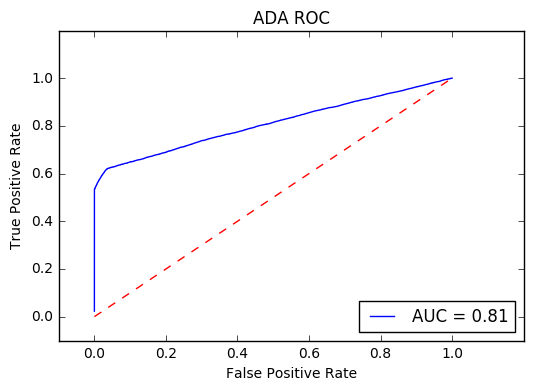

In [144]:
actual=y_test
y_pred = adagrid.predict_proba(X_test)
predictions = y_pred[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('ADA ROC')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [146]:
round(pd.DataFrame(np.stack((adagrid.best_estimator_.feature_importances_,std)).T,
                                    index=X_train.columns.get_values(),columns=['Imp','Var']),2).sort_values('Imp',ascending=False).head(5)

,Imp,Var
device_id_TimeUsed_before,0.320,2.740
Purch_Month_Jan,0.190,0.450
Sign_to_Purch_Same,0.180,0.440
Sign_to_Purch_day,0.120,39.960
signup_Month_Jan,0.070,0.480


In [1]:
# use SVM for high-dimentional classification

<div class="alert alert-block alert-info">
<b>Model 3: Supporting Vector Machine </b><br>
__Modeling__<br>
Used 2 kernels and rbf kernel achieved a better result   <br> 
Hyper parameter tuning by finding the best Gamma, which control the level of non-liarity of the hyperplane.  <br> 
__Result__<br>
The evaluation metrics does not improve much compared to logistic regression  <br> 
</div>

In [31]:
kernels = kernels = ['linear','rbf','poly']

for kernel in kernels:
    svc = svm.SVC(kernel=kernel).fit(X_train, y_train)
    pred=svc.predict(X_test)
    print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     68559
          1       0.79      0.54      0.64      6997

avg / total       0.94      0.94      0.94     75556



         1. Linear Kernel
             precision    recall  f1-score   support

          0       0.96      0.96      0.96     68559
          1       0.64      0.62      0.63      6997

          avg / total       0.93      0.93      0.93     75556
         
         2. RBF Kernel   
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     68559
          1       0.79      0.54      0.64      6997

          avg / total       0.94      0.94      0.94     75556
         
         RBF Kernel yields higher f1-score 

In [45]:
gammas=[0.01,0.1,1,10,100]
kernels = ['rbf']

for tune_gamma in gammas:
    svc = svm.SVC(gamma=tune_gamma,kernel = 'rbf').fit(X_train, y_train)
    pred=svc.predict(X_test)
    print('svm with rbf kernel and gamma={}'.format(tune_gamma))
    print(classification_report(y_test,pred))

        svm with rbf kernel and gamma=0.01
                     precision    recall  f1-score   support
        
                  0       0.95      0.99      0.97     68559
                  1       0.88      0.54      0.67      6997
        
        avg / total       0.95      0.95      0.94     75556
        
        svm with rbf kernel and gamma=0.1
                     precision    recall  f1-score   support
        
                  0       0.95      0.96      0.96     68559
                  1       0.60      0.55      0.57      6997
        
        avg / total       0.92      0.92      0.92     75556
        
        svm with rbf kernel and gamma=1
                     precision    recall  f1-score   support
        
                  0       0.95      1.00      0.98     68559
                  1       1.00      0.51      0.68      6997
        
        avg / total       0.96      0.95      0.95     75556
        
        svm with rbf kernel and gamma=10
                     precision    recall  f1-score   support
        
                  0       0.91      1.00      0.95     68559
                  1       0.00      0.00      0.00      6997
        
        avg / total       0.82      0.91      0.86     75556
        
      
        svm with rbf kernel and gamma=100
                     precision    recall  f1-score   support
        
                  0       0.91      1.00      0.95     68559
                  1       0.00      0.00      0.00      6997
        
        avg / total       0.82      0.91      0.86     75556

<div class="alert alert-block alert-info">
<b>Thank you for your time. Hope this analysis provided insights and will help prevent loss in real practice  </b><br>
</div>

<div class="alert alert-block alert-info">
*Yilun Guo - Modeling Demo - Fraud Analytics*  <br>
</div>